In [6]:
import math
import numpy as np

In [7]:
import matplotlib.pyplot as plt

In [8]:
%matplotlib inline

In [9]:
# Set the font family and size to use for Matplotlib figures.
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 16

In [1]:
# Set parameters.
g = 9.81 # gravitational acceleration (m.s^{-2})
vt = 30.0 # trim velocity (m/s)
CD = 1.0 / 40 # drag coefficient
CL = 1.0 # lift coefficient

# Set initial conditions.
v0 = vt # start at the trim velocity
theta0 = 0.0 # trajectory angle
x0 = 0.0 # horizontal position
y0 = 1000.0 # vertical position (altitude)

In [15]:
def rhs_phugoid(u, CL, CD, g, vt):
    """
    Returns the rhs of the phugoid system of equations.
    
    Parameters
    ----------
    u : list of np.ndarray
        Solution at the previous time step
        as a list or 1D array of four floats.
    CL : float
        Lift coefficient.
    CD : float
        Drag coefficient.
    g : float
        Gravitational acceleration.
    vt : float
        Trim velocity.
        
    Returns
    -------
    rhs : np.ndarray
            The rhs of the system
            as a 1D array of four floats.
    """
    v, theta, x, y = u
    rhs = np.array([-g * math.sin(theta) - CD / CL * g / vt**2 * v**2,
                    -g * math.cos(theta) / v + g / vt**2 * v,
                    v * math.cos(theta),
                    v * math.sin(theta)])
    return rhs

In [16]:
def euler_step(u, f, dt, *args):
    """
    Returns the solution at the next time step using Euler's method.
    
    Parameters
    ----------
    u : numpy.ndarray
        Solution at the previous time step
        as a 1D array of floats.
    f : function
        Function to compute the right-hand side of the system.
    dt : float
        Time-step size.
    args : tuple, optional
        Positional arguments to pass to the function f.
    
    Returns
    -------
    u_new : numpy.ndarray
        The solution at the next time step
        as a 1D array of floats.
    """
    u_new = u + dt * f(u, *args)
    return u_new

In [17]:
T = 100.0 # length of time interval
dt = 0.1 # time-step size
N = int(T / dt) + 1 # number of time steps

# Create array to store the solution at each time step.
u = np.empty((N, 4))

# Set the initial conditions
u[0] = np.array([v0, theta0, x0, y0])

# Time integration with Euler's method.
for n in range(N-1):
    u[n + 1] = euler_step(u[n], rhs_phugoid, dt, CL, CD, g, vt)

In [18]:
# Get the glider's position over the time.
x = u[:, 2]
y = u[:, 3]

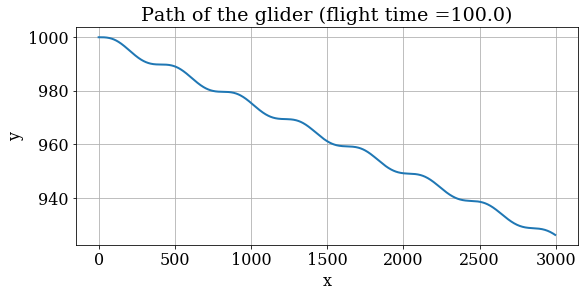

In [19]:
# Plot the path of the glider.
plt.figure(figsize=(9.0, 4.0))
plt.title('Path of the glider (flight time ={})'.format(T))
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.plot(x, y, color ='C0', linestyle='-', linewidth=2)

In [20]:
# Set the list of time-step sizes.
dt_values = [0.1, 0.05, 0.01, 0.005, 0.001]

# Create an empty list that will contain the solution of each grid.
u_values = []

for dt in dt_values:
    N = int(T / dt) + 1 # number of time-steps
    # Create array to store the solution at each time step.
    u = np.empty((N, 4))
    # Set the initial conditions.
    u[0] = np.array([v0, theta0, x0, y0])
    # Temporal integration using Euler's method.
    for n in range(N - 1):
        u[n + 1] = euler_step(u[n], rhs_phugoid, dt, CL, CD, g, vt)
    # Store the solution for the present time-step size
    u_values.append(u)

In [21]:
def l1_diff(u_coarse, u_fine, dt):
    """
    Returns the difference in the L1-norm between the solution on
    a coarse grid and the solution on a fine grid.
    
    Parameters
    ----------
    u_coarse : numpy.ndarray
        Solution on the coarse grid as an array of floats.
    u_fine : numpy.ndarray
        Solution on the fine grid as an array of floats.
    dt : float
        Time-step size.
    
    Returns
    -------
    diff : float
        The difference between the two solutions in the L1-norm
        scaled by the time-step size.
    """
    N_coarse = len(u_coarse)
    N_fine = len(u_fine)
    ratio = math.ceil(N_fine / N_coarse)
    diff = dt * np.sum(np.abs(u_coarse - u_fine[::ratio]))
    return diff

In [22]:
# Create an empty list to store the difference in the solution between the two consecutive grids
diff_values = []

for i, dt in enumerate(dt_values[:-1]):
    diff = l1_diff(u_values[i][:, 2], u_values[-1][:, 2], dt)
    diff_values.append(diff)

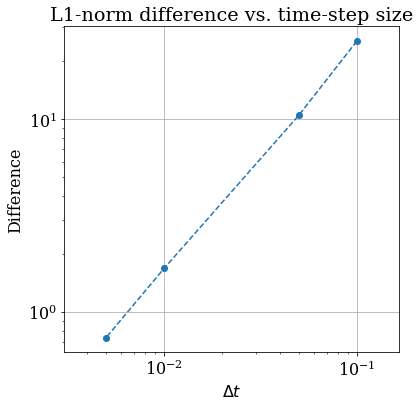

In [23]:
# Plot the difference versus the time-step size.
plt.figure(figsize=(6.0, 6.0))
plt.title('L1-norm difference vs. time-step size')  # set the title
plt.xlabel('$\Delta t$')  # set the x-axis label
plt.ylabel('Difference')  # set the y-axis label
plt.grid()
plt.loglog(dt_values[:-1], diff_values,
          color='C0', linestyle='--', marker='o')  #log-log plot
plt.axis('equal');  # make axes scale equally

In [25]:
r = 2 # refinement ratio for the time-step size
h = 0.001 # base grid size

dt_values2 = [h, r * h, r**2 * h]
u_values2 = []

for dt in dt_values2:
    N = int(T / dt) + 1 # number of time steps
    # Create array to store the solution at each time step.
    u = np.empty((N, 4))
    # Set the initial conditions.
    u[0] = np.array([v0, theta0, x0, y0])
    # Temporal integration using the Euler's method.
    for n in range(N - 1):
        u[n + 1] = euler_step(u[n], rhs_phugoid, dt, CL, CD, g, vt)
    # Store the solution.
    u_values2.append(u)
    
# Calculate f2 - f1.
f2_f1 = l1_diff(u_values2[1][:, 2], u_values2[0][:, 2], dt_values2[1])
# Calculate f3 - f2.
f3_f2 = l1_diff(u_values2[2][:, 2], u_values2[1][:, 2], dt_values2[2])
# Calculate the observed order of convergence.
p = math.log(f3_f2 / f2_f1) / math.log(r)
print('Observed order of convergence: p = {:.3f}'.format(p))

Observed order of convergence: p = 1.014
